**IMPORTING LIBRARIES**

In [124]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

**LOADING DATASET**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [125]:
data =pd.read_csv('/content/drive/MyDrive/IoT Network Intrusion Dataset/IoT Network Intrusion Dataset.csv')
data

,Flow_ID,Src_IP,Src_Port,Dst_IP,Dst_Port,Protocol,Timestamp,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,...,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label,Cat,Sub_Cat
0,192.168.0.13-192.168.0.16-10000-10101-17,192.168.0.13,10000,192.168.0.16,10101,17,25/07/2019 03:25:53 AM,75,1,1,...,0.0,0.0,0.0,75.0,0.000000,75.0,75.0,Anomaly,Mirai,Mirai-Ackflooding
1,192.168.0.13-222.160.179.132-554-2179-6,222.160.179.132,2179,192.168.0.13,554,6,26/05/2019 10:11:06 PM,5310,1,2,...,0.0,0.0,0.0,2655.0,2261.327486,4254.0,1056.0,Anomaly,DoS,DoS-Synflooding
2,192.168.0.13-192.168.0.16-9020-52727-6,192.168.0.16,52727,192.168.0.13,9020,6,11/07/2019 01:24:48 AM,141,0,3,...,0.0,0.0,0.0,70.5,0.707107,71.0,70.0,Anomaly,Scan,Scan Port OS
3,192.168.0.13-192.168.0.16-9020-52964-6,192.168.0.16,52964,192.168.0.13,9020,6,04/09/2019 03:58:17 AM,151,0,2,...,0.0,0.0,0.0,151.0,0.000000,151.0,151.0,Anomaly,Mirai,Mirai-Hostbruteforceg
4,192.168.0.1-239.255.255.250-36763-1900-17,192.168.0.1,36763,239.255.255.250,1900,17,10/09/2019 01:41:18 AM,153,2,1,...,0.0,0.0,0.0,76.5,0.707107,77.0,76.0,Anomaly,Mirai,Mirai-Hostbruteforceg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625778,192.168.0.24-210.89.164.90-56112-8043-17,192.168.0.24,56112,210.89.164.90,8043,17,25/07/2019 03:25:00 AM,277,1,1,...,0.0,0.0,0.0,277.0,0.000000,277.0,277.0,Anomaly,Mirai,Mirai-UDP Flooding
625779,192.168.0.13-222.131.171.244-554-4570-6,222.131.171.244,4570,192.168.0.13,554,6,26/05/2019 10:06:51 PM,1658,0,2,...,0.0,0.0,0.0,1658.0,0.000000,1658.0,1658.0,Anomaly,DoS,DoS-Synflooding
625780,192.168.0.13-192.168.0.16-9020-52739-6,192.168.0.16,52739,192.168.0.13,9020,6,11/07/2019 01:29:09 AM,77,1,1,...,0.0,0.0,0.0,77.0,0.000000,77.0,77.0,Anomaly,Scan,Scan Port OS
625781,192.168.0.13-192.168.0.16-9020-49784-6,192.168.0.13,9020,192.168.0.16,49784,6,20/05/2019 05:00:29 AM,240,2,1,...,0.0,0.0,0.0,120.0,7.071068,125.0,115.0,Normal,Normal,Normal


**PREPROCESSING AND DATA CLEANING**

In [126]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep]
data=clean_dataset(data)
data = data.to_numpy()

**LABEL ENCODING & Data Standardization**

In [127]:
np.random.shuffle(data) 
X=data[:,7:83]
Y=data[:,83]
Y[Y=='Anomaly']=0
Y[Y=='Normal']=1
minMax= MinMaxScaler()
X = minMax.fit_transform(X)
std = StandardScaler()
X = std.fit_transform(X)

**SPLITING DATA**

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=22)

**LSTM MODEL FOR BINARY CLASSIFICATION**

In [129]:
# The LSTM architecture
classifier = Sequential()
# First LSTM layer with Dropout regularisation
classifier.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
classifier.add(Dropout(0.2))
# Second LSTM layer
classifier.add(LSTM(units=50, return_sequences=True))
classifier.add(Dropout(0.2))
# Third LSTM layer
classifier.add(LSTM(units=50, return_sequences=True))
classifier.add(Dropout(0.2))
# Fourth LSTM layer
classifier.add(LSTM(units=50))
classifier.add(Dropout(0.2))
# The output layer
classifier.add(Dense(units=1))




**COMPILING AND TRAINING LSTM MODEL**

In [130]:
classifier.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
X_train = tf.convert_to_tensor(X_train,np.float32)
y_train = tf.convert_to_tensor(y_train,np.float32)
print(X_train.shape)
print(y_train.shape)
history=classifier.fit(X_train, y_train,epochs=10, batch_size=400)

(437790, 76)
(437790,)
Epoch 1/10
1095/1095 [==============================] - 35s 25ms/step - loss: 0.2051 - accuracy: 0.9433
Epoch 2/10
1095/1095 [==============================] - 26s 23ms/step - loss: 0.1628 - accuracy: 0.9519
Epoch 3/10
1095/1095 [==============================] - 25s 23ms/step - loss: 0.1505 - accuracy: 0.9575
Epoch 4/10
1095/1095 [==============================] - 26s 23ms/step - loss: 0.1277 - accuracy: 0.9693
Epoch 5/10
1095/1095 [==============================] - 25s 23ms/step - loss: 0.1069 - accuracy: 0.9772
Epoch 6/10
1095/1095 [==============================] - 25s 23ms/step - loss: 0.1040 - accuracy: 0.9793
Epoch 7/10
1095/1095 [==============================] - 25s 23ms/step - loss: 0.0955 - accuracy: 0.9819
Epoch 8/10
1095/1095 [==============================] - 25s 23ms/step - loss: 0.0935 - accuracy: 0.9829
Epoch 9/10
1095/1095 [==============================] - 25s 23ms/step - loss: 0.0876 - accuracy: 0.9834
Epoch 10/10
1095/1095 [==================

**EVALUTATING MODEL**

In [131]:
loss,accuracy = classifier.evaluate(tf.convert_to_tensor(X_test,np.float32),tf.convert_to_tensor(y_test,np.float32))
print("Loss: ", loss)
print('Accuracy: ',accuracy*100)

5864/5864 [==============================] - 48s 8ms/step - loss: 0.0785 - accuracy: 0.9831
Loss:  0.07847286015748978
Accuracy:  98.31472635269165


**Visualizing Results**

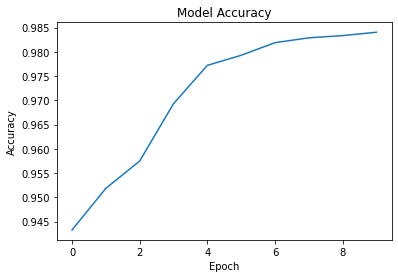

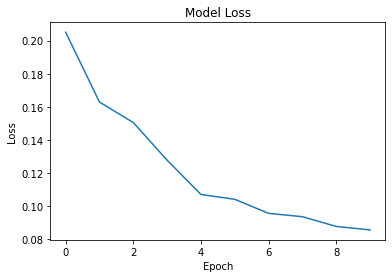

In [132]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

**LOADING DATA AGAIN BUT THIS TIME FOR MULTICLASS CLASSIFICATION**

In [133]:
X = data[:,7:85]
Y = data[:, 85]

**ONE HOT ENCODING THE INDEPENDENT FEATURES**

In [134]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [76, 77])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

**REPLACING THE MISSING VALUES WITH THE MEAN OF THAT COLUMN**

In [135]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(X)
X = imputer.transform(X)

In [136]:
X

array([[  1.        ,   0.        ,   0.        , ...,   0.        ,
        158.        , 158.        ],
       [  1.        ,   0.        ,   0.        , ...,   0.        ,
        265.        , 265.        ],
       [  1.        ,   0.        ,   0.        , ...,   0.        ,
        138.        , 138.        ],
       ...,
       [  1.        ,   0.        ,   0.        , ...,  26.87005769,
        109.        ,  71.        ],
       [  1.        ,   0.        ,   0.        , ...,   0.70710678,
         74.        ,  73.        ],
       [  1.        ,   0.        ,   0.        , ...,   0.        ,
         83.        ,  83.        ]])

**DATA STANDARDIZATION**

In [137]:
minMax= MinMaxScaler()
X = minMax.fit_transform(X)
std = StandardScaler()
X = std.fit_transform(X)

**ENCODING LABELS AND PRING UNIQUE VALUES AFTER LABEL ENCODING**

In [138]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Y = le.fit_transform(Y)
b = []
for i in Y:
    if i not in b:
        b.append(i)
print (b)

[8, 5, 4, 2, 3, 1, 0, 7, 6]


**SPLITING THE DATA FOR TRAINING AND TESTING THE MODEL**

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=22)

**LSTM MODEL FOR MULTICLASS CLASSIFICATION**

In [140]:
# The LSTM architecture
classifier = Sequential()
# First LSTM layer with Dropout regularisation
classifier.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
classifier.add(Dropout(0.2))
# Second LSTM layer
classifier.add(LSTM(units=50, return_sequences=True))
classifier.add(Dropout(0.2))
# Third LSTM layer
classifier.add(LSTM(units=50, return_sequences=True))
classifier.add(Dropout(0.2))
# Fourth LSTM layer
classifier.add(LSTM(units=50))
classifier.add(Dropout(0.2))
# The output layer
classifier.add(Dense(units=9, activation='softmax'))

**COMPILING AND TRAINING LSTM MODEL**

In [141]:
classifier.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
X_train = tf.convert_to_tensor(X_train,np.float32)
y_train = tf.convert_to_tensor(y_train,np.float32)
print(X_train.shape)
print(y_train.shape)
history=classifier.fit(X_train, y_train,epochs=10, batch_size=400)

(437790, 83)
(437790,)
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1095/1095 [==============================] - 33s 26ms/step - loss: 0.8304 - accuracy: 0.6694
Epoch 2/10
1095/1095 [==============================] - 28s 25ms/step - loss: 0.6032 - accuracy: 0.7300
Epoch 3/10
1095/1095 [==============================] - 27s 25ms/step - loss: 0.7098 - accuracy: 0.7096
Epoch 4/10
1095/1095 [==============================] - 27s 25ms/step - loss: 0.5857 - accuracy: 0.7353
Epoch 5/10
1095/1095 [==============================] - 28s 25ms/step - loss: 0.5628 - accuracy: 0.7423
Epoch 6/10
1095/1095 [==============================] - 27s 25ms/step - loss: 0.5399 - accuracy: 0.7495
Epoch 7/10
1095/1095 [==============================] - 27s 25ms/step - loss: 0.5310 - accuracy: 0.7523
Epoch 8/10
1095/1095 [==============================] - 27s 25ms/step - loss: 0.5242 - accuracy: 0.7531
Epoch 9/10
1095/1095 [==============================] - 27s 25ms/step - loss: 0.5183 - accuracy: 0.7542
Epoch 10/10
1095/1095 [==============================] - 27s 25ms/step - lo

**EVALUTATING MODEL**

In [142]:
loss,accuracy = classifier.evaluate(tf.convert_to_tensor(X_test,np.float32),tf.convert_to_tensor(y_test,np.float32))
print("Loss: ", loss)
print('Accuracy: ',accuracy*100)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5864/5864 [==============================] - 51s 8ms/step - loss: 0.5107 - accuracy: 0.7535
Loss:  0.5107100605964661
Accuracy:  75.34976601600647


**Visualizing Results**

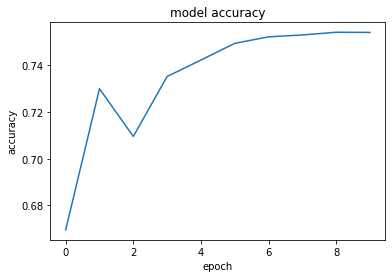

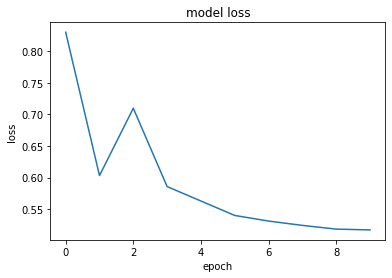

In [143]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()  